In [2]:
from matplotlib import pyplot as plt
import japanize_matplotlib
import numpy as np
from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.decomposition import FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import torch, random
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader

In [3]:
df_bc = load_breast_cancer()

In [4]:
df_bc["target"] = (df_bc["target"] - 1) * -1
target_names = ["良性", "悪性"]
for i, name in enumerate(target_names):
    print("{}: {}".format(name, (df_bc["target"] == i).sum()))

良性: 357
悪性: 212


In [5]:
def plot_lr(x, y, coef, intercept, xrange=17):
    wx = (np.dot(coef, x.T) + intercept)
    z = 1 / (1 + np.exp(-wx))
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].plot(np.linspace(-17, 17, 100), 1 / (1 + np.exp(-np.linspace(-17, 17, 100))), c="C2", zorder=-1, label="シグモイド関数")
    for i, label in enumerate(target_names):
        ax[0].scatter(wx[y == i], z[y == i], alpha=0.5, zorder=i, label=label)
    ax[0].hlines(y=0.5, xmin=-xrange, xmax=xrange, linestyle="--", color="r", zorder=-2)
    ax[0].legend()
    ax[0].set_ylabel("予測値")
    ax[0].set_xlabel("線形計算の結果")

    ax[1].boxplot([z[y == i] for i in range(2)], sym="", vert=False, positions=[0, 1], medianprops=dict(color='black', linewidth=2))
    for i in range(2):
        ind = y == i
        ax[1].scatter(z[ind], np.zeros_like(z[ind]) + i + np.random.normal(0, 0.02, size=sum(ind)), alpha=0.5)
    ax[1].vlines(x=0.5, ymin=-0.4, ymax=1.4, linestyle="--", color="r", zorder=-1)
    ax[1].set_yticks([0, 1])
    ax[1].set_yticklabels(target_names)
    ax[1].set_xlabel("予測値")
    ax[1].set_xlim(-0.1, 1.1)
    plt.tight_layout()

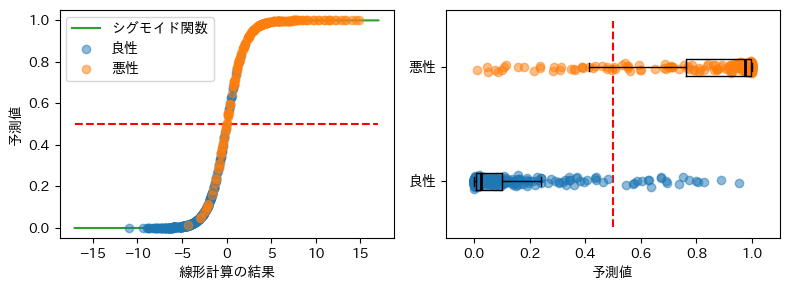

In [6]:
model = LogisticRegression()
model.fit(df_bc["data"][:, :4], df_bc["target"])
plot_lr(df_bc["data"][:, :4], df_bc["target"], model.coef_[0], model.intercept_)
plt.savefig("img/lr_example.png")

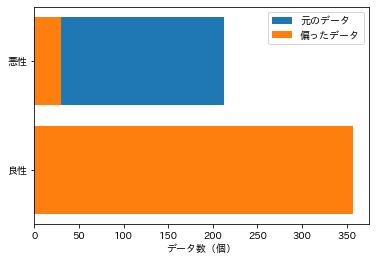

In [56]:
n_malignant = 30

ind_bc = np.hstack([np.where(df_bc["target"] == 0)[0], np.where(df_bc["target"] == 1)[0][:n_malignant]])
data_bc = df_bc["data"][ind_bc, :4]
data_bc = (data_bc - data_bc.mean()) / data_bc.std()
data_bc = torch.from_numpy(data_bc).float()
target_bc = torch.from_numpy(df_bc["target"][ind_bc].reshape(-1, 1)).float()

plt.barh([0, 1], [(df_bc["target"] == i).sum() for i in range(2)], label="元のデータ")
plt.barh([0, 1], [(target_bc == i).sum().item() for i in range(2)], label="偏ったデータ")
plt.yticks([0, 1], ["良性", "悪性"])
plt.xlabel("データ数（個）")
plt.legend()

(array([ 0., 55., 68., 61.,  6.,  5.,  2.,  3.,  4.,  0.]),
 array([ 25. ,  57.1,  89.2, 121.3, 153.4, 185.5, 217.6, 249.7, 281.8,
        313.9, 346. ]),
 <BarContainer object of 10 artists>)

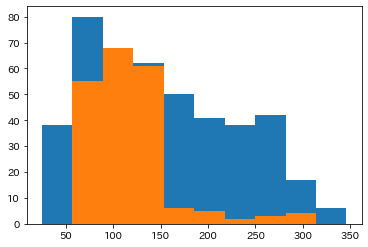

In [142]:
remove_rate = 10

df_di = load_diabetes()
target_di = df_di["target"]
target_di = (target_di - target_di.mean()) / target_di.std()
ind_di = np.hstack([np.where((target_di <= 0) & (target_di >= -1.1))[0], np.where(target_di > 0)[0][::remove_rate]])
data_di = torch.from_numpy(df_di["data"][ind_di, :]).float()
target_di = torch.from_numpy(target_di[ind_di].reshape(-1, 1)).float()
b = plt.hist(df_di["target"])
plt.hist(df_di["target"][ind_di], bins=b[1])

In [143]:
class Simple(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.l1 = nn.Linear(in_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.l1(x)
        return self.sigmoid(x)

In [144]:
class MyDataset(Dataset):
    def __init__(self, data, label):
        super().__init__()
        self.data = data
        self.label= label

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.label)

In [145]:
class BalancedLoss(nn.Module):
    def __init__(self, y):
        super().__init__()
        n = len(y)
        n0 = sum(y == 0)
        n1 = n - n0
        self.a = n / (2 * n0)
        self.b = n / (2 * n1)
    
    def forward(self, outputs, targets):
        tmp = torch.square(outputs - targets)
        tmp[targets == 0] *= self.a
        tmp[targets == 1] *= self.b
        return tmp.sum()

In [146]:
def fix_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [212]:
def train(net, criterion, data, target, seed=0, n_epoch=200):
    fix_seeds(seed)
    model = net(data.shape[1], 1)
    optimizer = Adam(model.parameters(), lr=1e-3)
    dataset = MyDataset(data, target)
    dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)
    save_loss = np.zeros(n_epoch)
    for epoch in range(n_epoch):
        ls = 0.0
        for inputs, targets in dataloader:
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            ls += loss.item()
            loss.backward()
            optimizer.step()
        save_loss[epoch] = ls
        
    plt.plot(save_loss)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.tight_layout()
    plt.show()
    return model

In [208]:
mse_loss = nn.MSELoss()
balanced_loss = BalancedLoss(target_bc)

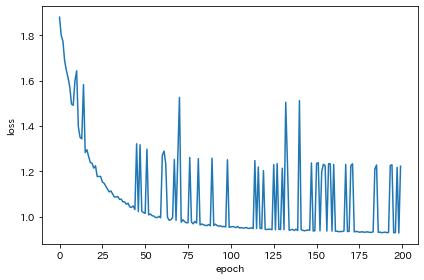

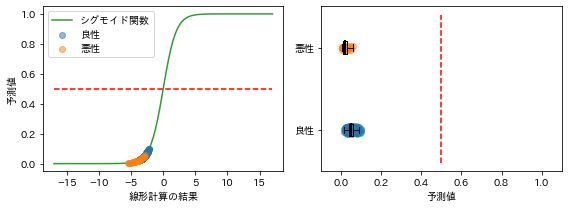

In [213]:
model_mse = train(Simple, mse_loss, data_bc, target_bc, seed=0)
plot_lr(data_bc.detach().numpy(), target_bc.detach().numpy()[:, 0], 
        model_mse.l1.weight.detach().numpy()[0], model_mse.l1.bias.detach().numpy())

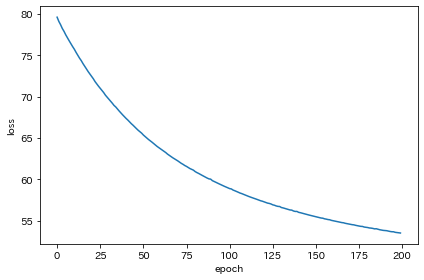

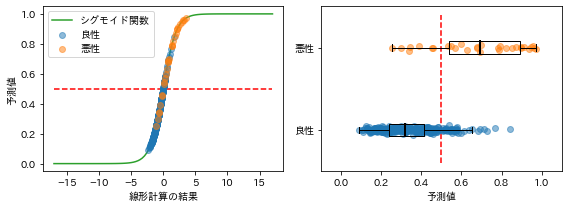

In [229]:
model_balanced = train(Simple, balanced_loss, data_bc, target_bc, seed=1)
outputs_balanced = model_balanced(data_bc)
plot_lr(data_bc.detach().numpy(), target_bc.detach().numpy()[:, 0], 
        model_balanced.l1.weight.detach().numpy()[0], model_balanced.l1.bias.detach().numpy())

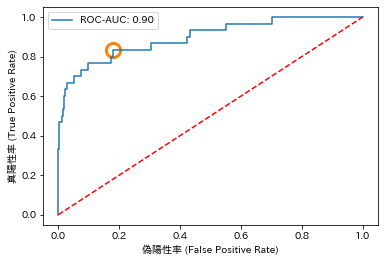

In [231]:
outputs_numpy = outputs_balanced.detach().numpy().reshape(-1)
target_numpy = target_bc.detach().numpy().reshape(-1)
fpr, tpr, thresholds = roc_curve(target_numpy, outputs_numpy)
print()
plt.plot(fpr, tpr, c="C0", label="ROC-AUC: {:.2f}".format(roc_auc_score(target_numpy, outputs_numpy)))
plt.plot([0, 1], [0, 1], c="r", linestyle="--")
i = sum(fpr < 0.2) - 1
plt.scatter([fpr[i]], [tpr[i]], c="w", s=200, edgecolors="C1", linewidth=3)
plt.xlabel("偽陽性率 (False Positive Rate)")
plt.ylabel("真陽性率 (True Positive Rate)")
plt.legend()
plt.show()

In [218]:
class TwoLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dim=10):
        super().__init__()
        self.l1 = nn.Linear(in_dim, dim)
        self.relu = nn.LeakyReLU()
        self.l2 = nn.Linear(dim, out_dim)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        return self.l2(x)

In [232]:
def plot_reg(outputs, targets):
    target_numpy = targets.detach().numpy().reshape(-1)
    ind = target_numpy.argsort()
    plt.plot(target_numpy[ind], label="真の値")
    plt.plot(outputs.detach().numpy().reshape(-1)[ind], label="予測値")
    plt.ylabel("真の値・予測値 (スケール済み)")
    plt.xlabel("データID (真の値に基づいてソート)")
    plt.legend()

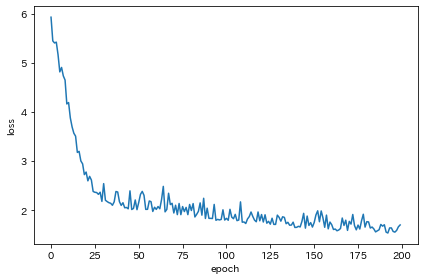

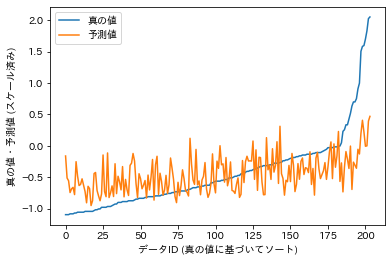

In [233]:
model_mse = train(TwoLayer, mse_loss, data_di, target_di, seed=2)
plot_reg(model_mse(data_di), target_di)

In [224]:
class CenteredLoss(nn.Module):
    def __init__(self, y):
        super().__init__()
        n = len(y)
        tn = y[y < 0]
        tp = y[y >= 0]
        sn = sum(tn)
        sp = sum(tp)
        rn = sum(tn * tn)
        rp = sum(tp * tp)
        den = sp * rn - sn * rp
        self.wn = sp * n / den
        self.wp = -sn * n / den
    
    def forward(self, outputs, targets):
        tmp = torch.square(outputs - targets)
        tmp[targets < 0] *= self.wn
        tmp[targets >= 0] *= self.wp
        return tmp.sum()

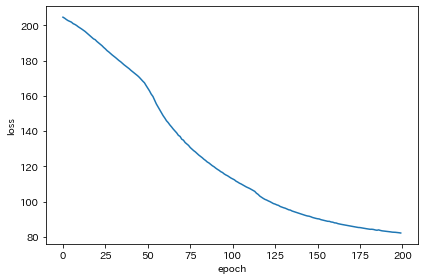

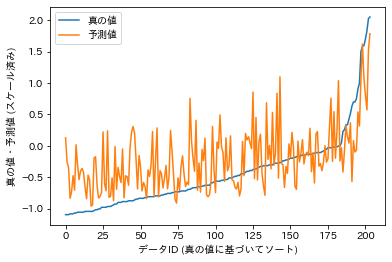

In [235]:
centered_loss = CenteredLoss(target_di)
model_centered = train(TwoLayer, centered_loss, data_di, target_di, seed=3)
outputs_centered = model_centered(data_di)
plot_reg(outputs_centered, target_di)

In [244]:
print("分類モデル")
print("学習後の誤差: {:.2f}".format(balanced_loss(outputs_balanced, target_bc)))
print("Nullモデルの誤差: {:.2f}".format(balanced_loss(torch.zeros_like(outputs_balanced) + 0.5, target_bc)))

分類モデル
学習後の誤差: 53.46
Nullモデルの誤差: 96.75


In [243]:
print("回帰モデル")
print("学習後の誤差: {:.2f}".format(centered_loss(outputs_centered, target_di)))
print("Nullモデルの誤差: {:.2f}".format(centered_loss(torch.zeros_like(outputs_centered), target_di)))

回帰モデル
学習後の誤差: 81.98
Nullモデルの誤差: 204.00


In [245]:
data_bc_benign = data_bc[target_bc[:, 0] == 0]
xm = data_bc - data_bc_benign.mean(axis=0)
cov_inv = torch.inverse(data_bc_benign.T.cov())
mahal = (xm * torch.matmul(xm, cov_inv)).sum(axis=1).detach().numpy()

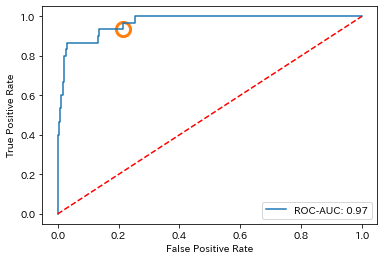

In [246]:
target_numpy = target_bc.detach().numpy().reshape(-1) == 1
fpr, tpr, thresholds = roc_curve(target_numpy, mahal)
print()
plt.plot(fpr, tpr, c="C0", label="ROC-AUC: {:.2f}".format(roc_auc_score(target_numpy, mahal)))
plt.plot([0, 1], [0, 1], c="r", linestyle="--")
i = sum(fpr < 0.2)
plt.scatter([fpr[i]], [tpr[i]], c="w", s=200, edgecolors="C1", linewidth=3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [269]:
ica = FastICA(n_components=2, random_state=42)
ica.fit(data_bc_benign)
data_bc_ica = ica.transform(data_bc)

Text(0, 0.5, '第2独立成分')

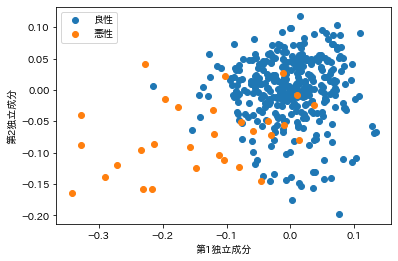

In [272]:
for i in range(2):
    plt.scatter(data_bc_ica[target_bc[:, 0] == i, 0], data_bc_ica[target_bc[:, 0] == i, 1], label=target_names[i])
plt.legend()
plt.xlabel("第1独立成分")
plt.ylabel("第2独立成分")